<a href="https://colab.research.google.com/github/MaryamAshraff2/unsupervised-housing-clustering/blob/main/kmedoids_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LIBRARY INSTALLATION**

In [1]:
!pip install numpy pandas matplotlib scikit-learn scipy -q

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

**DATA SET UPLAODING**

In [3]:
from google.colab import files
import pandas as pd
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(filename)
display(df)

Saving housing - housing (1).csv to housing - housing (1).csv


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,78100,INLAND
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,77100,INLAND
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,92300,INLAND
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,84700,INLAND


**PREPROCESSING DATASET**

In [4]:
# Preprocessing
numerical_features = df.drop(columns=['ocean_proximity', 'median_house_value'])
imputer = SimpleImputer(strategy='median')
numerical_features_imputed = imputer.fit_transform(numerical_features)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_imputed)
data = np.array(numerical_features_scaled)


In [5]:
display(pd.DataFrame(data, columns=numerical_features.columns))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881
...,...,...,...,...,...,...,...,...
20635,-0.758826,1.801647,-0.289187,-0.444985,-0.388283,-0.512592,-0.443449,-1.216128
20636,-0.818722,1.806329,-0.845393,-0.888704,-0.922403,-0.944405,-1.008420,-0.691593
20637,-0.823713,1.778237,-0.924851,-0.174995,-0.123608,-0.369537,-0.174042,-1.142593
20638,-0.873626,1.778237,-0.845393,-0.355600,-0.304827,-0.604429,-0.393753,-1.054583


**K MEDOID FUNCTION**

In [6]:
def initialize_medoids(data, k):
    return data[random.sample(range(data.shape[0]), k)]

def assign_clusters(data, medoids):
    distances = cdist(data, medoids, metric='euclidean')
    return np.argmin(distances, axis=1)

**CHOSING OPTIMAL VALUE FOR K**

In [7]:
from tqdm import tqdm  # For progress bar

def compute_total_cost(data, medoids, labels):
    cost = 0
    for i, medoid in enumerate(medoids):
        cluster_points = data[labels == i]
        cost += np.sum(np.linalg.norm(cluster_points - medoid, axis=1))
    return cost

def k_medoids(data, k, max_iter=100):
    medoids = initialize_medoids(data, k)
    for _ in range(max_iter):
        labels = assign_clusters(data, medoids)
        new_medoids = []
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) == 0:
                continue
            # Calculate total distance from each point to all others
            distances = cdist(cluster_points, cluster_points, 'euclidean')
            total_distances = distances.sum(axis=1)
            new_medoid = cluster_points[np.argmin(total_distances)]
            new_medoids.append(new_medoid)
        new_medoids = np.array(new_medoids)
        if np.allclose(medoids, new_medoids):
            break
        medoids = new_medoids
    labels = assign_clusters(data, medoids)
    return medoids, labels


In [8]:
distortions = []
silhouettes = []
K_range = range(2, 11)

for k in tqdm(K_range):
    medoids, labels = k_medoids(data, k)
    cost = compute_total_cost(data, medoids, labels)
    distortions.append(cost)
    score = silhouette_score(data, labels)
    silhouettes.append(score)


100%|██████████| 9/9 [02:36<00:00, 17.40s/it]


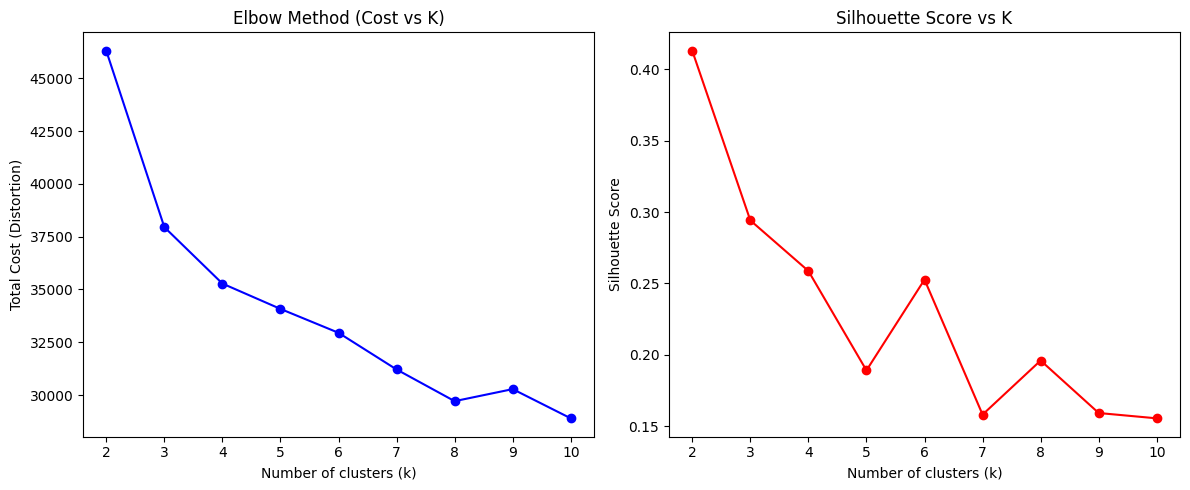

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, distortions, 'bo-')
plt.title('Elbow Method (Cost vs K)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total Cost (Distortion)')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, 'ro-')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [10]:
# Automatically pick k with highest silhouette score
optimal_k = K_range[np.argmax(silhouettes)]
print(f"Optimal k based on silhouette score: {optimal_k}")


Optimal k based on silhouette score: 2


**FINAL CLUSTERING**

In [11]:
final_medoids, final_labels = k_medoids(data, optimal_k)


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
medoids_2d = pca.transform(final_medoids)


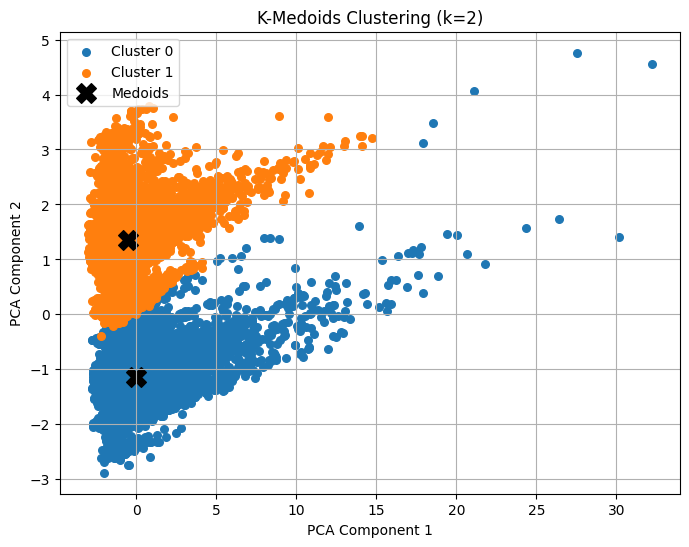

In [13]:
plt.figure(figsize=(8, 6))

for i in range(optimal_k):
    plt.scatter(
        data_2d[final_labels == i, 0],
        data_2d[final_labels == i, 1],
        label=f'Cluster {i}',
        s=30
    )

plt.scatter(
    medoids_2d[:, 0],
    medoids_2d[:, 1],
    c='black',
    marker='X',
    s=200,
    label='Medoids'
)

plt.title(f'K-Medoids Clustering (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()
